In [190]:
import numpy as np
import pandas as pd 
import statsmodels.formula.api as smf 
import seaborn as sns 
import scipy.stats as stats
import io
import re

In [162]:
df = pd.read_csv('https://raw.githubusercontent.com/Shevyakow/-/main/insurance.csv')
df['charges']=np.log(df['charges'])
df.rename(columns={'charges':'log_charges'}, inplace=True)
df['sex'] = df['sex'].replace(['male','female'], ['1', '0'])
#df['smoker'] = df['smoker'].replace(['yes','no'], ['1', '0'])
df

,age,sex,bmi,children,smoker,region,log_charges
0,19,0,27.900,0,yes,southwest,9.734176
1,18,1,33.770,1,no,southeast,7.453302
2,28,1,33.000,3,no,southeast,8.400538
3,33,1,22.705,0,no,northwest,9.998092
4,32,1,28.880,0,no,northwest,8.260197
...,...,...,...,...,...,...,...
1333,50,1,30.970,3,no,northwest,9.268661
1334,18,0,31.920,0,no,northeast,7.698927
1335,18,0,36.850,0,no,southeast,7.396233
1336,21,0,25.800,0,no,southwest,7.604867


$$
chrges=\beta_1*age+\beta_2*sex+\beta_3*children+\beta_4*bmi
$$

In [218]:
fitted_line = smf.ols(formula='log_charges~age+children+bmi', data=df).fit() 
fitted_line.params.round(2)

Intercept    7.32
age          0.03
children     0.11
bmi          0.01
dtype: float64

## Спецификация
$$
log(charges)=7.32+0.03*age+0.11*children+0.01*bmi
$$

# Интерпретация
### При увеличении  возраста на 1 год, стоимость страховки увеличивается на 3%, при увеличении количества детей (людей), на которых распространяется страховка, на 1 её стоимость увеличивается на 11%. При увеличении индекса массы тела на 1 стоимость страховки увеличивается на 1%. 

<AxesSubplot:xlabel='bmi', ylabel='log_charges'>

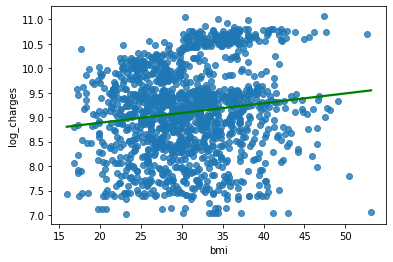

In [109]:
sns.regplot(data=df, y='log_charges', x='bmi', ci=None, line_kws={"color": "g"})

In [110]:
fitted_polynom = smf.ols(formula='log_charges~age+children+bmi', data=df).fit() 
fitted_polynom.params.round(2)

Intercept    7.32
age          0.03
children     0.11
bmi          0.01
dtype: float64

<AxesSubplot:xlabel='bmi', ylabel='log_charges'>

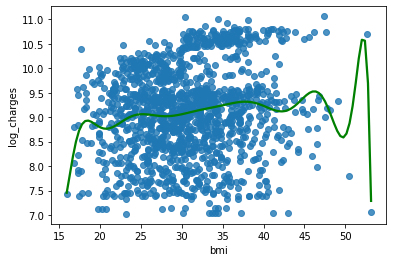

In [126]:
sns.regplot(data=df, y='log_charges', x='bmi',order=13, ci=None, line_kws={"color": "g"})

# При увеличении порядка регрессионной кривой, точность регрессии увеличивается вплоть до 13 порядка

In [127]:
fitted_line.ess.round(3)

343.058

In [128]:
fitted_line.centered_tss.round(3)

1130.474

In [129]:
fitted_line.ssr.round(3)

787.415

# T-тест (1 способ)


In [130]:
de=fitted_line.summary(alpha=0.05).tables[1]
de

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,7.3189,0.119,61.643,0.000,7.086,7.552
age,0.0336,0.002,22.331,0.000,0.031,0.037
children,0.1057,0.017,6.058,0.000,0.071,0.140
bmi,0.0113,0.003,3.252,0.001,0.004,0.018


In [131]:
fitted_line.t_test('age=0')

<class 'statsmodels.stats.contrast.ContrastResults'>
                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0             0.0336      0.002     22.331      0.000       0.031       0.037

# Критическое значение Стьюдента меньше чем наблюдаемое, следовательно коэффициент $ age$ значим. Возраст влияет на стоимость страховки

In [226]:
t_cr=stats.t.ppf(1-0.05/2,len(df)-4)
t_cr.round(3)

1.962

In [135]:
fitted_line.t_test('children=0')

<class 'statsmodels.stats.contrast.ContrastResults'>
                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0             0.1057      0.017      6.058      0.000       0.071       0.140

# Критическое значение Стьюдента меньше чем наблюдаемое, следовательно коэффициент $ children$ значим. Количество детей(людей), вписанных в страховку влияет на её стоимость. 

In [134]:
fitted_line.t_test('bmi=0')

<class 'statsmodels.stats.contrast.ContrastResults'>
                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0             0.0113      0.003      3.252      0.001       0.004       0.018

In [133]:
t_cr=stats.t.ppf(1-0.05/2,len(df)-4)
t_cr.round(3)

1.962

# Наблюдаемое значение Стьюдента больше чем критическое, значит коэффициент $bmi$ значим. Индекс массы тела влияет на стоимость страховки. 

# Т-тест (2 способ)


In [136]:
strr='''coef  std.err t 
Intercept 7.3189 0.119 61.643 
age 0.0336 0.002 22.331 
children   0.1057   0.017   6.058
bmi  0.0113  0.003   3.252'''
ded=pd.read_csv(io.StringIO(strr), delimiter='\s+')
ded['Значение'] =np.abs(ded['coef']/ded['std.err'])
alpha = 0.05
t_cr1 = stats.t.ppf(1 - alpha/2, len(df)-4)
ded['Значимость'] = ded.apply(lambda x : 'значимо' if abs(x['Значение']) > t_cr1 else 'не значимо', axis=1)
ded

,coef,std.err,t,Значение,Значимость
Intercept,7.3189,0.119,61.643,61.503361,значимо
age,0.0336,0.002,22.331,16.800000,значимо
children,0.1057,0.017,6.058,6.217647,значимо
bmi,0.0113,0.003,3.252,3.766667,значимо


# Все коэффициенты регрессии значимы

# F-тест

# $$H_0:age=bmi=0$$


In [145]:
fitted_line1 = smf.ols(formula='log_charges~age+bmi', data=df).fit() 
R2_1=fitted_line.rsquared.round(3)
R2_2=fitted_line1.rsquared.round(3)
print(R2_1,R2_2)
unrest, rest = np.float_(re.findall(r'([-+]?\d+.\d+)','R2                      0.303          0.284'))
F_nab=(unrest-rest)/(1-unrest)*(len(df)-4)/2
F_nab
alpha=0.05
F_cr = stats.f.ppf(1-alpha,2,len(de)-4)
print(F_nab.round(3),F_cr.round(3))

0.303 0.284
18.182 199.5


# $ F_{nab}<F_{cr} \rightarrow$ совместное влияние коэффициентов $age$ и $bmi$ незначимо

# $$H_0:children=bmi=0$$

In [147]:
fitted_line2 = smf.ols(formula='log_charges~children+bmi', data=df).fit() 
R2_1=fitted_line.rsquared.round(3)
R2_2=fitted_line2.rsquared.round(3)
print(R2_1,R2_2)
unrest, rest = np.float_(re.findall(r'([-+]?\d+.\d+)','R2                      0.303          0.043'))
F_nab=(unrest-rest)/(1-unrest)*(len(df)-4)/2
F_nab
alpha=0.05
F_cr = stats.f.ppf(1-alpha,2,len(de)-4)
print(F_nab.round(3),F_cr.round(3))

0.303 0.043
248.809 199.5


# $ F_{nab}>F_{cr} \rightarrow$ совместное влияние коэффициентов $children$ и $bmi$ значимо

# $$H_0:age=children=0$$

In [149]:
fitted_line3 = smf.ols(formula='log_charges~children+age', data=df).fit() 
R2_1=fitted_line.rsquared.round(3)
R2_2=fitted_line3.rsquared.round(3)
print(R2_1,R2_2)
unrest, rest = np.float_(re.findall(r'([-+]?\d+.\d+)','R2                      0.303          0.298'))
F_nab=(unrest-rest)/(1-unrest)*(len(df)-4)/2
F_nab
alpha=0.05
F_cr = stats.f.ppf(1-alpha,2,len(de)-4)
print(F_nab.round(3),F_cr.round(3))

0.303 0.298
4.785 199.5


# $ F_{nab}<F_{cr} \rightarrow$ совместное влияние коэффициентов $age$ и $children$ незначимо

# Структурные сдвиги

In [165]:
df_default = df[df['smoker']=='no']
df_ndefault = df[df['smoker']=='yes']
duf = smf.ols(data=df, formula='log_charges~age+children+bmi').fit()
d_default = smf.ols(data= df_default, formula='log_charges~age+children+bmi').fit()
d_ndefault = smf.ols(data= df_ndefault, formula='log_charges~age+children+bmi').fit()
F_obs=(duf.ssr-(d_default.ssr+d_ndefault.ssr))/(d_default.ssr+d_ndefault.ssr)*((len(df_default)+len(df_ndefault)-2*3)/(3))
F_obs.round(3)
alpha = 0.05
F_cr=stats.f.ppf(1-alpha,3,len( df_default ) + len( df_ndefault ) - 6  )
print(F_obs.round(3), F_cr.round(3))

1294.921 2.612


# $ F_{nab}>F_{cr} =>$ стурктурные изменения значимы

# Доверительный интервал

In [185]:
string=''' 
Intercept   7.3189   0.119
age	0.0336   0.002
children   0.1057   0.017
bmi   0.0113   0.003'''
dn = pd.DataFrame(np.reshape(string.strip().split(), (4,3) ), columns=['Coeff','Est str','std.err. str'])
dn['Estimate'] = dn['Est str'].str.extract(r'([-+]?\d+.\d+)').astype(float)
dn['Std.error'] = dn['std.err. str'].str.extract(r'([-+]?\d+.\d+)').astype(float)
dn['нижняя'] = (dn['Estimate'] - dn['Std.error']*t_cr1).round(2)
dn['верхняя'] = (dn['Estimate'] + dn['Std.error']*t_cr1).round(2)
dn= dn.drop(['Coeff','Est str','std.err. str', 'Estimate', 'Std.error'], axis=1)
dn

,нижняя,верхняя
0,7.09,7.55
1,0.03,0.04
2,0.07,0.14
3,0.01,0.02


# Гетеросхедостичность

In [219]:
df['res2']=fitted_line.resid**2
df['res']=fitted_line.resid
sub_model= smf.ols(data=df, formula='res2~age+children+bmi').fit()
St = np.round(len(df)*sub_model.rsquared,2)
Hi2 = stats.chi2.ppf(1-0.05,3)
print(St,Hi2)

296.75 7.814727903251179


# $St>Hi^2 \rightarrow$ тест указывает на гетерсхедостичность

# Серийная корреляция

$ H_0: \rho =0 $, $H_1: \rho \neq 0$

In [220]:
model = smf.ols(data=df, formula='log_charges~age+children+bmi').fit()
model.params.round(2)
resSq = sum(model.resid**2)
sum_resid = 0
for i in range(len(model.resid)-1):
    sum_resid+=(model.resid[i+1]-model.resid[i])**2
print(sum_resid/resSq)

2.026942909201159


# Значение тестовой статистики Дарбина-Уотсона находится в промежутке от 2 до 4 $\rightarrow$ $H_0$ об отсутствии серийной корреляции отвергается. Наблюдается серийная корреляция. 